In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [0]:
from scipy.io import loadmat
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

In [0]:
from PIL import Image

row = 180
col = 180
datab = np.empty([200,row,col,1], dtype = np.uint8)
dataf = np.empty([200,row,col,1], dtype = np.uint8)
datan = np.empty([200,row,col,1], dtype = np.uint8)
datao = np.empty([200,row,col,1], dtype = np.uint8)
path = './train'

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


for i in range(200):
    if i%20 ==0:
      print(i)
    
    imgb = rgb2gray(mpimg.imread(path+ "/" + str(i + 1)+'b.jpg'))
    imgb = cv2.resize(imgb, dsize=(row, col))
    imgf = rgb2gray(mpimg.imread(path+ "/" + str(i + 1)+'f.jpg'))
    imgf = cv2.resize(imgf, dsize=(row, col))
    imgn = rgb2gray(mpimg.imread(path+ "/" + str(i + 1)+'n.jpg'))
    imgn = cv2.resize(imgn, dsize=(row, col))
    imgo = rgb2gray(mpimg.imread(path+ "/" + str(i + 1)+'o.jpg'))
    imgo = cv2.resize(imgo, dsize=(row, col)) 

    datab[i] = imgb.reshape(row,col,1)
    dataf[i] = imgf.reshape(row,col,1)
    datan[i] = imgn.reshape(row,col,1)
    datao[i] = imgo.reshape(row,col,1)

0
20
40
60
80
100
120
140
160
180


In [0]:
ratio = 0.75
slc = int(ratio * datab.shape[0])
x_train = datan[:slc]
y_train = datao[:slc]
x_test = datan[slc:]
y_test = datao[slc:]
x_train=x_train.astype('float32')/255.
y_train=y_train.astype('float32')/255.
y_train2=y_train-x_train+0.5
x_test=x_test.astype('float32')/255.
y_test=y_test.astype('float32')/255.
y_test2=y_test-x_test+0.5
y_train.shape

(150, 180, 180, 1)

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
layer1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer10 = layers.Conv2D(1, (3, 3), activation='relu', padding='same')

In [0]:
#define iterations and learning rate of ODP
A = tf.ones([row, col, 1], tf.float32)
A = tf.multiply(A, -0.5)
it = 3 # number of iterations
alpha = 0.5

#define layers of CNN
#weights = tf.get_variable(name='weights', shape=[5, 5, 3, 16], dtype=tf.float32)
input_img = layers.Input(shape=(row, col, 1)) 
y = input_img

x = input_img
for i in range(it):
  #if i == 0:
    #x = input_img
  #else:
    #x = output
  x_shortcut = x # save for residual process
  x = layer1(x)
  x = layer2(x) 
  x = layer3(x) 
  x = layer4(x) 
  x = layer5(x) 
  x = layer6(x) 
  x = layer7(x) 
  x = layer8(x) 
  x = layer9(x) 
  x = layer10(x)
  x = tf.add(x_shortcut, x)
  x = tf.add(A, x) # reduce x by 0.5. Otherwise x in previous step would be negative.
  ya = tf.multiply(y, alpha)
  x = tf.add(x, ya)
  x = tf.multiply(x, 1/(1+alpha))
  alpha = alpha/2

output = x
ODP = models.Model(input_img, output)
ODP.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [0]:
input_img = layers.Input(shape=(row, col, 1))
y_shortcut = input_img
y = layer1(input_img)
y = layer2(y) 
y = layer3(y) 
y = layer4(y) 
y = layer5(y) 
y = layer6(y) 
y = layer7(y) 
y = layer8(y) 
y = layer9(y) 
y = layer10(y)
y = tf.add(y_shortcut, y)
y = tf.add(A, y) 
CNN = models.Model(input_img, y)
CNN.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [0]:
ODP.summary()


In [0]:
CNN.summary()


In [0]:
with tf.device('/device:GPU:0'):
  ODP.fit(x_train, y_train,
                epochs=25,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 150 samples, validate on 50 samples
Epoch 1/25
150/150 [==============================] - 6s 42ms/sample - loss: 0.3543 - val_loss: 0.1084
Epoch 2/25
150/150 [==============================] - 5s 31ms/sample - loss: 0.0488 - val_loss: 0.0197
Epoch 3/25
150/150 [==============================] - 5s 31ms/sample - loss: 0.0208 - val_loss: 0.0196
Epoch 4/25
150/150 [==============================] - 5s 31ms/sample - loss: 0.0112 - val_loss: 0.0074
Epoch 5/25
150/150 [==============================] - 5s 31ms/sample - loss: 0.0058 - val_loss: 0.0042
Epoch 6/25
150/150 [==============================] - 5s 31ms/sample - loss: 0.0031 - val_loss: 0.0027
Epoch 7/25
150/150 [==============================] - 5s 31ms/sample - loss: 0.0024 - val_loss: 0.0023
Epoch 8/25
150/150 [==============================] - 5s 31ms/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 9/25
150/150 [==============================] - 5s 31ms/sample - loss: 0.0022 - val_loss: 0.0022
Epoch 10/25
150/150 [=======

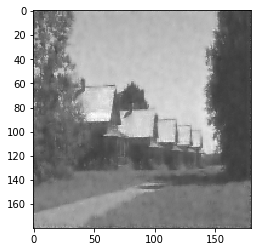

In [0]:
#20 epoch 2 it resnet
y_pred = ODP.predict(x_test, batch_size = 10)
#plt.imshow(x_test[0,:,:,0]+y_pred[0,:,:,0]-0.5, cmap='gray')

plt.imshow(y_pred[0,:,:,0], cmap='gray')

In [0]:
mse = np.linalg.norm(y_pred[0,:,:,0]-y_test[0,:,:,0],axis=(0,1))
mse

5.971219

In [0]:
MSE=[5.971219, 5.4896946, 7.511013, 9.007295, 8.430302]

In [0]:
comp = np.empty([200,row,col,1], dtype = np.uint8)
path = './compare'

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
for i in range(5):
    imgb = rgb2gray(mpimg.imread(path+ "/" + str(5*i + 10)+'n.jpg'))
    imgb = cv2.resize(imgb, dsize=(row, col))
    comp[i] = imgb.reshape(row,col,1)
comp=comp.astype('float32')/255.

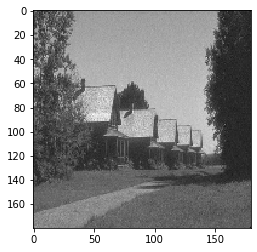

In [0]:
#20 epoch 1 it ODP
y_pred = ODP.predict(comp)
#plt.imshow(x_test[0,:,:,0]+y_pred[0,:,:,0]-0.5, cmap='gray')

plt.imshow(y_pred[0,:,:,0], cmap='gray')

In [0]:
mse = np.linalg.norm(y_pred[0,:,:,0]-y_test[0,:,:,0],axis=(0,1))
mse

3.8851542

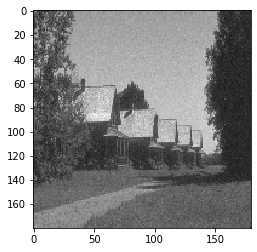

In [0]:
plt.imshow(y_pred[1,:,:,0], cmap='gray')

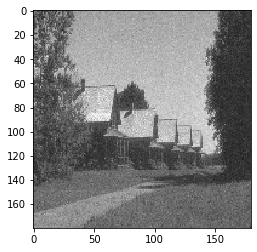

In [0]:
plt.imshow(y_pred[2,:,:,0], cmap='gray')

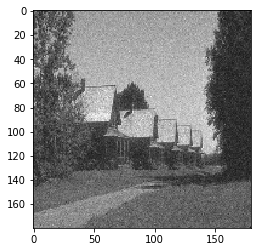

In [0]:
plt.imshow(y_pred[3,:,:,0], cmap='gray')

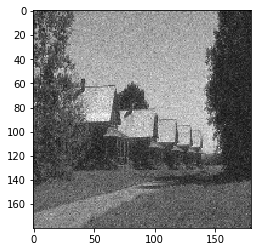

In [0]:
plt.imshow(y_pred[4,:,:,0], cmap='gray')

In [0]:
MSEODPINI1=[]
for i in range(5):
  MSEODPINI1.append( np.linalg.norm(y_pred[i,:,:,0]-comp[i,:,:,0],axis=(0,1)))

In [0]:
MSEODP3=[]
for i in range(5):
  MSEODP3.append( np.linalg.norm(y_pred[i,:,:,0]-y_test[0,:,:,0],axis=(0,1)))
MSEODP3

[3.8851542, 5.200035, 6.6732697, 8.039234, 9.522681]

In [0]:
MSEPLG=[]
for i in range(5):
  MSEPLG.append( np.linalg.norm(y_pred[i,:,:,0]-comp[i,:,:,0],axis=(0,1)))

In [0]:
MSEODPINI3=[]
for i in range(5):
  MSEODPINI3.append( np.linalg.norm(y_pred[i,:,:,0]-comp[i,:,:,0],axis=(0,1)))

In [0]:
MSECNN=[]
for i in range(5):
  MSECNN.append( np.linalg.norm(y_pred[i,:,:,0]-comp[i,:,:,0],axis=(0,1)))

In [0]:
MSEODPINI=[]
for i in range(5):
  MSEODPINI.append( np.linalg.norm(y_pred[i,:,:,0]-comp[i,:,:,0],axis=(0,1)))

In [0]:
a=[10,15,20,25,30]

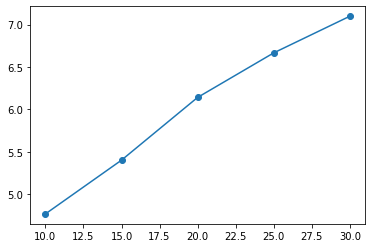

In [0]:
plt.plot(a, MSEODPINI3 ,marker='o')

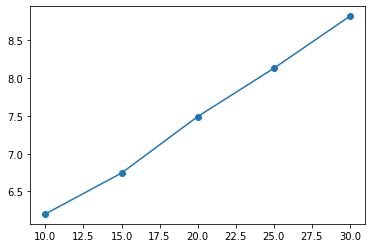

In [0]:
plt.plot(a, MSEPLG ,marker='o')

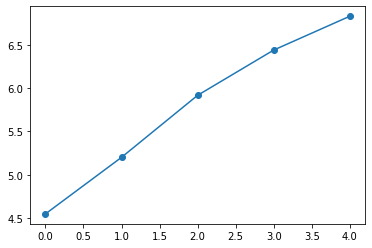

In [0]:
plt.plot(MSEODPINI4 ,marker='o')

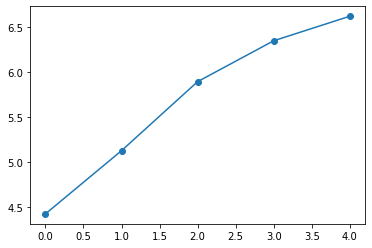

In [0]:
plt.plot(MSEODPINI ,marker='o')

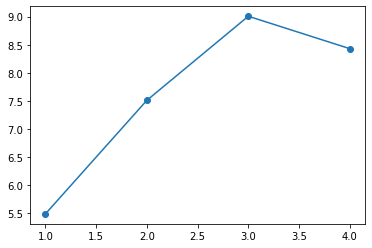

In [0]:
a=[1,2,3,4]
plt.plot(a, MSE[1:], marker='o')

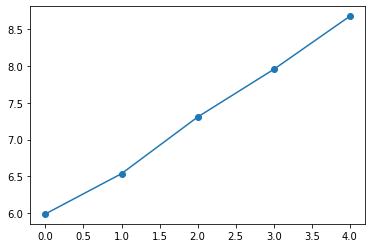

In [0]:
a=[1,2,3,4]
plt.plot(MSEODP ,marker='o')

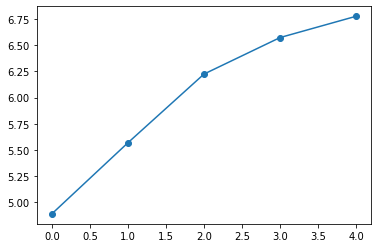

In [0]:
a=[]
plt.plot(MSECNN, marker='o')

In [0]:
with tf.device('/device:GPU:0'):
  CNN.fit(x_train, y_train,
                epochs=25,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 150 samples, validate on 50 samples
Epoch 1/25
150/150 [==============================] - 4s 26ms/sample - loss: 0.0653 - val_loss: 0.0097
Epoch 2/25
150/150 [==============================] - 2s 11ms/sample - loss: 0.0056 - val_loss: 0.0034
Epoch 3/25
150/150 [==============================] - 2s 11ms/sample - loss: 0.0035 - val_loss: 0.0027
Epoch 4/25
150/150 [==============================] - 2s 11ms/sample - loss: 0.0025 - val_loss: 0.0022
Epoch 5/25
150/150 [==============================] - 2s 11ms/sample - loss: 0.0022 - val_loss: 0.0021
Epoch 6/25
150/150 [==============================] - 2s 10ms/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 7/25
150/150 [==============================] - 2s 11ms/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 8/25
150/150 [==============================] - 2s 11ms/sample - loss: 0.0021 - val_loss: 0.0021
Epoch 9/25
150/150 [==============================] - 2s 11ms/sample - loss: 0.0021 - val_loss: 0.0020
Epoch 10/25
150/150 [=======

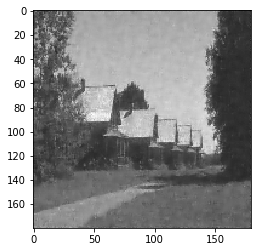

In [0]:
#25 epoch 4 it ODP
y_pred = CNN.predict(x_test, batch_size = 10)
#plt.imshow(x_test[0,:,:,0]+y_pred[0,:,:,0]-0.5, cmap='gray')
plt.imshow(y_pred[0,:,:,0], cmap='gray')

In [0]:
mse = np.linalg.norm(y_pred[0,:,:,0]-y_test[0,:,:,0],axis=(0,1))
mse

5.2054806

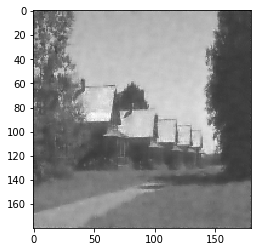

In [0]:
#25 epoch 2 it ODP
y_pred = ODP.predict(x_test, batch_size = 10)
#plt.imshow(x_test[0,:,:,0]+y_pred[0,:,:,0]-0.5, cmap='gray')
plt.imshow(y_pred[0,:,:,0], cmap='gray')

In [0]:
mse = np.linalg.norm(y_pred[0,:,:,0]-y_test[0,:,:,0],axis=(0,1))
mse

5.706736

In [0]:
MSE

NameError: ignored

In [0]:
MSECNN = [4.888424, 5.567847, 6.2245917, 6.5735455, 6.777159]

In [0]:
MSEODP = [5.98996, 6.5364027, 7.3051767, 7.9521985, 8.673825]

In [0]:
MSEODPINI2 = [4.420153, 5.123961, 5.892401, 6.3476615, 6.620523]

In [0]:
MSEODPINI4 = [4.54887, 5.201345, 5.916806, 6.438946, 6.8291698]

In [0]:
MSEPLG = [6.202749, 6.7435164, 7.49017, 8.129138, 8.818973]

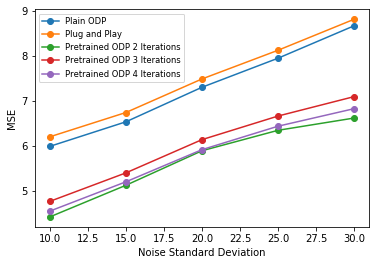

In [0]:

plt.plot(a,MSEODP, marker='o')
plt.plot(a,MSEPLG, marker='o')
plt.plot(a,MSEODPINI, marker='o')
plt.plot(a,MSEODPINI3, marker='o')
plt.plot(a,MSEODPINI4, marker='o')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('MSE')
plt.legend(['Plain ODP', 'Plug and Play', 'Pretrained ODP 2 Iterations', 'Pretrained ODP 3 Iterations', 'Pretrained ODP 4 Iterations'],fontsize='small')
plt.show()

###Deblur

In [0]:
from PIL import Image

row = 180
col = 180
datab = np.empty([200,row,col,1], dtype = np.uint8)
dataf = np.empty([200,row,col,1], dtype = np.uint8)
#datan = np.empty([200,row,col,1], dtype = np.uint8)
#datao = np.empty([200,row,col,1], dtype = np.uint8)
path = './train'

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


for i in range(200):
    if i%20 ==0:
      print(i)
    
    imgb = rgb2gray(mpimg.imread(path+ "/" + str(i + 1)+'b.jpg'))
    imgb = imgb[:row,:col]
    imgf = rgb2gray(mpimg.imread(path+ "/" + str(i + 1)+'f.jpg'))
    imgf = imgf[:row,:col]
    #imgn = rgb2gray(mpimg.imread(path+ "/" + str(i + 1)+'n.jpg'))
    #imgn = cv2.resize(imgn, dsize=(row, col))
    #imgo = rgb2gray(mpimg.imread(path+ "/" + str(i + 1)+'o.jpg'))
    #imgo = cv2.resize(imgo, dsize=(row, col)) 

    datab[i] = imgb.reshape(row,col,1)
    dataf[i] = imgf.reshape(row,col,1)
    #datan[i] = imgn.reshape(row,col,1)
    #datao[i] = imgo.reshape(row,col,1)

0
20
40
60
80
100
120
140
160
180


In [0]:
import cv2

img = cv2.imread(path+'/151o.jpg', cv2.IMREAD_GRAYSCALE)

size = 15

# generating the kernel
kernel_motion_blur = np.zeros((size, size))
kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
kernel_motion_blur = kernel_motion_blur / size

for i in range(200):
  datab[i] = cv2.filter2D(datan[i], -1, kernel_motion_blur).reshape(row,col,1)

plt.imshow(datab[0,:,:,0], cmap='gray')

In [0]:
kernel_motion_blur.shape

(15, 15)

In [0]:
ratio = 0.75
slc = int(ratio * datab.shape[0])
x_train = datab[:slc]
y_train = datao[:slc]
x_test = datab[slc:]
y_test = datao[slc:]
x_train=x_train.astype('float32')/255.
y_train=y_train.astype('float32')/255.
y_train2=y_train-x_train+0.5
x_test=x_test.astype('float32')/255.
y_test=y_test.astype('float32')/255.
y_test2=y_test-x_test+0.5
y_train.shape

(150, 180, 180, 1)

In [0]:
k = kernel_motion_blur
kT = tf.Variable(k.transpose())
#kT = tf.cast(kT, dtype=tf.float32)
k = tf.Variable(k)
k = tf.cast(k, dtype=tf.complex64)
K = tf.signal.fft2d(k) 
Ki = np.linalg.pinv(K)
Ki = np.float32(Ki)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [0]:
layer1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
layer10 = layers.Conv2D(1, (3, 3), activation='relu', padding='same')

In [0]:
#define iterations and learning rate of ODP
A = tf.ones([row, col, 1], tf.float32)
A = tf.multiply(A, -0.5)
it = 2 # number of iterations
alpha = 0.01

#define layers of CNN
#weights = tf.get_variable(name='weights', shape=[5, 5, 3, 16], dtype=tf.float32)
input_img = layers.Input(shape=(row, col, 1)) 
y = input_img

x = input_img
for i in range(it):
  #if i == 0:
    #x = input_img
  #else:
    #x = output
  x_shortcut = x # save for residual process
  x = layer1(x)
  x = layer2(x) 
  x = layer3(x) 
  x = layer4(x) 
  x = layer5(x) 
  x = layer6(x) 
  x = layer7(x) 
  x = layer8(x) 
  x = layer9(x) 
  x = layer10(x)
  x = tf.add(x_shortcut, x)
  x = tf.add(A, x) # reduce x by 0.5. Otherwise x in previous step would be negative.
  ya = tf.multiply(y, alpha)
  x = tf.add(x, ya)
  x = tf.multiply(x, 1/(1+alpha))
  alpha = alpha/2

output = x
ODP = models.Model(input_img, output)
ODP.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


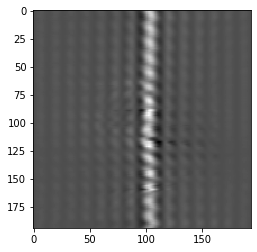

In [0]:
import scipy.signal
x = x_test[0].reshape(row,col)
x = np.fft.fft2(x)
K = kernel_motion_blur
K = np.fft.fft2(K)
K = np.linalg.pinv(K)

x = scipy.signal.convolve2d(x,K)
x = np.fft.ifft2(x)
x = np.float32(x)
plt.imshow(x, cmap='gray')

In [0]:
with tf.device('/device:GPU:0'):
  ODP.fit(x_train, y_train,
                epochs=5,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 150 samples, validate on 50 samples
Epoch 1/5
150/150 [==============================] - 3s 21ms/sample - loss: 0.0063 - val_loss: 0.0069
Epoch 2/5
150/150 [==============================] - 3s 21ms/sample - loss: 0.0063 - val_loss: 0.0059
Epoch 3/5
150/150 [==============================] - 3s 21ms/sample - loss: 0.0059 - val_loss: 0.0057
Epoch 4/5
150/150 [==============================] - 3s 21ms/sample - loss: 0.0057 - val_loss: 0.0055
Epoch 5/5
150/150 [==============================] - 3s 21ms/sample - loss: 0.0055 - val_loss: 0.0055


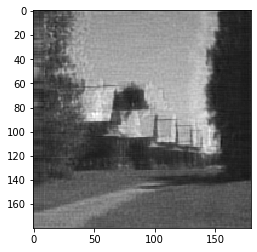

In [0]:
#25 epoch CNN
y_pred = CNN.predict(x_test, batch_size = 10)
#plt.imshow(x_test[0,:,:,0]+y_pred[0,:,:,0]-0.5, cmap='gray')
plt.imshow(y_pred[0,:,:,0], cmap='gray')

In [0]:
mse = np.linalg.norm(y_pred[0,:,:,0]-y_test[0,:,:,0],axis=(0,1))
mse

9.197472

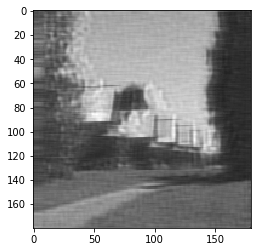

In [0]:
#25 epoch CNN
y_pred = ODP.predict(x_test, batch_size = 10)
#plt.imshow(x_test[0,:,:,0]+y_pred[0,:,:,0]-0.5, cmap='gray')
plt.imshow(y_pred[0,:,:,0], cmap='gray')

In [0]:
mse = np.linalg.norm(y_pred[0,:,:,0]-y_test[0,:,:,0],axis=(0,1))
mse

9.897454

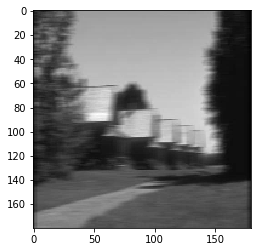

In [0]:
plt.imshow(x_test[0,:,:,0], cmap='gray')

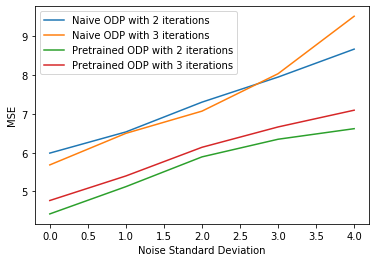

In [0]:
plt.plot(MSEODP)
plt.plot(MSEODP3)
plt.plot(MSEODPINI2)
plt.plot(MSEODPINI3)
plt.xlabel('Noise Standard Deviation')
plt.ylabel('MSE')
plt.legend(['Naive ODP with 2 iterations', 'Naive ODP with 3 iterations', 'Pretrained ODP with 2 iterations', 'Pretrained ODP with 3 iterations'])
plt.show()

In [0]:
MSEODP3

In [0]:
(MSEODP[-1]-MSEODPINI3[-1])/MSEODP[-1]

0.18174252732153098